<a href="https://colab.research.google.com/github/ankitaggarwal64/Time-Series-Sales-Forecasting-for-Agricultural-Equipments/blob/main/Univariate_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling and Evaluation:

**Modelling:**


Based on the simplicity and proven effective of statistical ARIMA modelling, we decided to use this method for both univariate and multivaraiate modelling. The way ARIMA modelling works is that it aims to learn the
linear relationships and the autocorrelations present in the data.
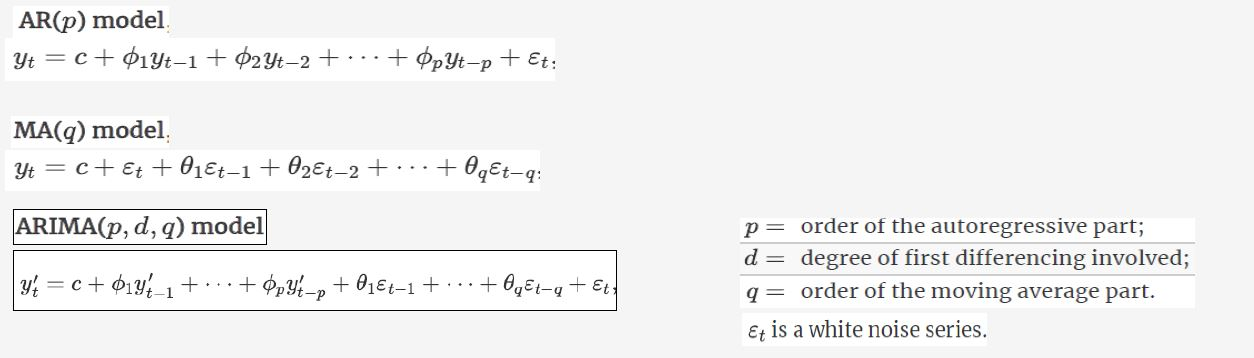



**Evaluation**

We considered following metrics during evaluation of methods:

Primary Metrics:
- RMSE (Root Mean Squared Error)

Other Metrics:
- MAPE - measures the relative dispersion of forecast errors
- Prediction Interval : Range of values in which prediction will fall.This metric represents the model uncertainity.
- MAD (Mean Absolute Deviation) : Mean deviation per period in absolute terms between a number of period forecasts and the corresponding period demand.
- Bias : Measures whether the forecast is overestimating or underestimating
the actual demand over the forecast horizon. It is basically commulative sum of errors. 
- Tracking Signal: Tracking signal at period k, is the ratio of Bias and MAD up to period k. It is commonly used for monitoring forecast accuracy.



**Observations & Results Summary from ARIMA modelling:**



*   ARIMA Test Results : {'Test RMSE': 125.36, 'Test MAPE': 25.22, 'Test Average Prediction Interval': 433.39}
*   Our selected model is  underforecasting consistently during the validation period and overcasting during the test period. One of the possible reasons for this might be the lack of additional required information or model inability to learn some patterns like cyclicity in the data.




**I. ARIMA Forecasting (Univariate modelling)**


In [7]:
#import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import pylab
plt.style.use('fivethirtyeight')

In [2]:
#import sales and indices combined data
combined_sales_ind = pd.read_csv("/content/drive/My Drive/1. Data Science/Sales Forecasting_Masters Project/Masters Project/Data/Output_files/combined_sales_ind.csv",parse_dates=['Time'], index_col='Time')

In [3]:
# Univariate Sales data
sales = combined_sales_ind["Sales"]

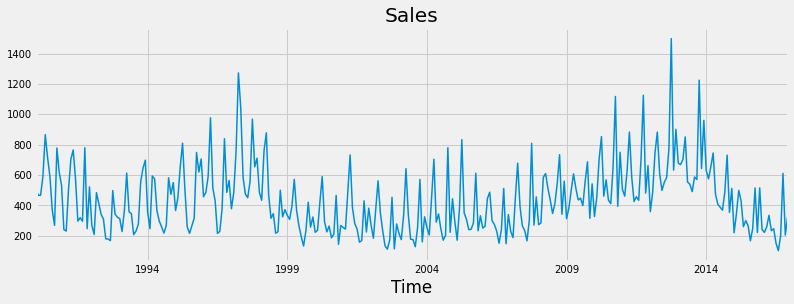

In [4]:
# Line plot of Sales time series
plt.style.use("fivethirtyeight")
ax = sales.plot(subplots= False,linewidth=1.5,sharex=False,sharey=False, figsize=(12,4),fontsize=10)
plt.title("Sales")
plt.show()

## Obseravtion : There is clear cyclicity and seasonality

**Train and Test Split:**

*   Train data : 1990 to 2012 (23 years)
*   Test data : 2013 to 2016 (4 Years)





In [5]:
# Train and Test Split
split_point = len(sales)-48 #Upto Dec-2012
train,test = sales[0:split_point],sales[split_point:]
print('Train %d, Test %d' % (len(train),len(test)))

Train 276, Test 48


**Model Paramater Estimation:**

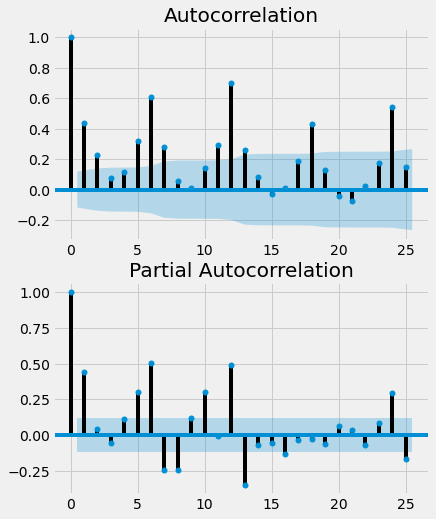

In [8]:
#Plot ACF and PACF

pylab.rcParams['figure.figsize'] = (6,8)
pyplot.figure()
pyplot.subplot(211)
plot_acf(train, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(train, lags=25, ax=pyplot.gca())
pyplot.show()

#OBSERVATIONS:
#There is a clear seasonality of 12 as seen in the peaks of ACF plot
#There is a possibility of both AR and MA terms because of geometric decay on ACF plot and significant autocorrelation of particular lags on PACF plot

In [9]:
# Define the p, d and q parameters possible values
p = range(0, 3)
d = range(0, 2)
q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
# specify to ignore warning messages
warnings.filterwarnings("ignore") 

# Grid Cross validation for best parameters estimation
columns = ['param','param_seasonal','aic']
rows = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            row = [param, param_seasonal, results.aic]
            rows.append(row)

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

models_aic = pd.DataFrame(rows, columns=columns)

In [ ]:
# Select the best parameters by lowest parameter values
models_aic.sort_values(by=["aic"])

**Model Training:**

In [11]:
#Intantiate the model with best Model Paramter
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(2, 1, 1),
                                seasonal_order=(2, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit training
results = mod.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [12]:
# Model Summary Statistics
print(results.summary())

# Observation : High probability of Ljung-Box repesents lack of autocorrelation 

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  276
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -1423.885
Date:                            Tue, 23 Feb 2021   AIC                           2861.769
Time:                                    20:20:24   BIC                           2886.046
Sample:                                01-31-1990   HQIC                          2871.554
                                     - 12-31-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2549      0.104      2.439      0.015       0.050       0.460
ar.L2         -0.0081      0.095   

In [13]:
# Checking Residual Summary Statistics
results.resid.describe()

# Obseration : Residual mean is near to zero.

count    276.000000
mean       2.844843
std      128.327317
min     -627.950001
25%      -66.983611
50%        3.871339
75%       59.058790
max      524.688753
dtype: float64

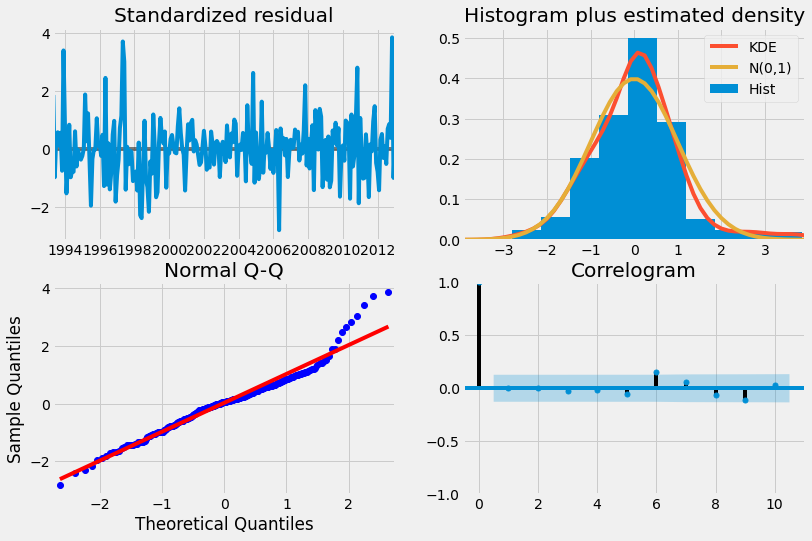

In [ ]:
# Residual diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# Obervation: Based on plots, residuls seems to be close to white noise, normally distributed and does not seems to have any significant autocorrelation

**Walk Forward Validation (2 step ahead):**

*   Two months ahead future forecast is considered since it's most impactful, since most of the supply chain(including components ordering) is confirmed two months in advance of the sales month
*   We  decided to consider 6 years as the period for walk forward validation to evalute our model performance during validation.






In [14]:
# Walk Forward validation
min_train_len = len(train)-6*12-1 # upto Nov-2006
forcast_horizon = 2 # Two months advance forecast is considered

In [ ]:
# Creating list to store model validation metrics during walk forward validation
columns_val = ["Index","Observed", "Forecast(mean)","Upper_forecast","Lower_forecast","Length_Predicion_Interval","MAD",'Bias',"Tracking_Signal"]
rows_val = []
Sum_forecast_error = 0
Sum_abs_forecast_error = 0
MAD = 0

In [ ]:
# Calculating  evaluation metrics during walk forward validation
for i in range(0,(6*12)):
  start= min_train_len+i # index for start of prediction
  end = min_train_len+i+(forcast_horizon-1) # Index for end of prediction
  pred_dynamic = results.get_prediction(start= start, end = end , dynamic=True)
  pred_dynamic_ci = pred_dynamic.conf_int()

  # Extract the predicted and true values of our time series
  y_val_forecasted = pred_dynamic.predicted_mean[forcast_horizon-1]
  y_val_truth = train[end]

  # Length of Prediction Interval(95% CI)
  Upper_forecast =pred_dynamic_ci.iloc[forcast_horizon-1,:]["upper Sales"]
  Lower_forecast =pred_dynamic_ci.iloc[forcast_horizon-1,:]["lower Sales"]
  len_prediction_interval = Upper_forecast - Lower_forecast

  # Forecast Error
  forecast_error = y_val_truth - y_val_forecasted

  # Absolute Forecast Error
  abs_forecast_error = abs(y_val_truth - y_val_forecasted)

  # Compute Commulative forecast error 
  Sum_forecast_error = Sum_forecast_error + forecast_error

  # Compute Commulative Absolute Forecast Error
  Sum_abs_forecast_error = Sum_abs_forecast_error + abs_forecast_error

  # Mean Absolute Deviation
  MAD = Sum_abs_forecast_error/(i+1)

  # Bias
  Bias = Sum_forecast_error/(i+1)

  # Tracking Signal
  Tracking_signal = Sum_forecast_error/MAD

  row = [train[[end]].index.date[0] ,y_val_truth,y_val_forecasted, Upper_forecast,Lower_forecast,len_prediction_interval,MAD, Bias,Tracking_signal]
  rows_val.append(row)

In [ ]:
# Validation Error & Metrics from 2007 to 2012 with forecast horizon of 2 months
val_metrics = pd.DataFrame(rows_val, columns=columns_val)
val_metrics = val_metrics.set_index('Index')
display(val_metrics)

,Observed,Forecast(mean),Upper_forecast,Lower_forecast,Length_Predicion_Interval,MAD,Bias,Tracking_Signal
Index,,,,,,,,
2007-01-31,230,209.268426,422.206915,-3.670063,425.876978,20.731574,20.731574,1.000000
2007-02-28,188,181.264782,394.201985,-31.672421,425.874405,13.733396,13.733396,2.000000
2007-03-31,449,381.161630,594.098084,168.225176,425.872908,31.768387,31.768387,3.000000
2007-04-30,678,605.039075,817.974829,392.103321,425.871508,42.066522,42.066522,4.000000
2007-05-31,394,315.507372,528.442872,102.571873,425.870998,49.351743,49.351743,5.000000
...,...,...,...,...,...,...,...,...
2012-08-31,583,464.813260,677.744640,251.881880,425.862760,72.647686,12.739028,11.924040
2012-09-30,774,694.068294,906.999674,481.136915,425.862759,72.753252,13.712835,13.005407
2012-10-31,1498,1103.904947,1316.836326,890.973568,425.862759,77.343849,19.146867,17.328859


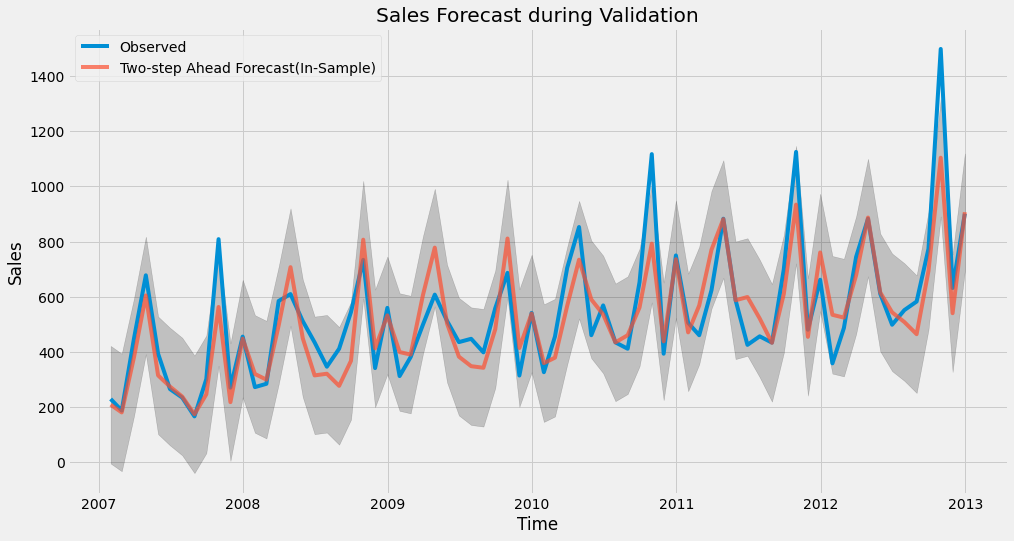

In [ ]:
# Plotting Sales v/s Time forecast during validation
ax = val_metrics["Observed"].plot(label='Observed',figsize=(15, 8))
val_metrics["Forecast(mean)"].plot(ax=ax, label='Two-step Ahead Forecast(In-Sample)', alpha=.7)
ax.fill_between(val_metrics.index,val_metrics.iloc[:,3],val_metrics.iloc[:,2], color='k', alpha=.2)
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
plt.title("Sales Forecast during Validation")
plt.legend()

plt.show()

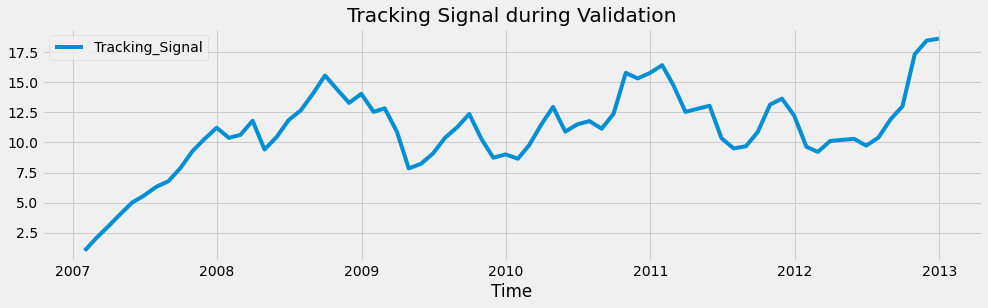

In [ ]:
#Plotting Tracking Signal
ax = val_metrics["Tracking_Signal"].plot(figsize=(15,4))
plt.title("Tracking Signal during Validation")
ax.set_xlabel('Time')
plt.legend()
plt.show()

# Observation: Since our tracking signal is continuosly above 4.5 , we can say that our model is underforecasting most of the time.

In [ ]:
# Calculating RMSE during validation

# Compute the Root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(val_metrics["Observed"], val_metrics["Forecast(mean)"]))

# Calculating MAPE during validation
percent_forecast_errors = abs(val_metrics["Observed"] - val_metrics["Forecast(mean)"])*100/val_metrics["Observed"] 
MAPE = sum(percent_forecast_errors)*1.0/len(percent_forecast_errors)

# Prediction Interval
Prediction_interval = val_metrics["Length_Predicion_Interval"].mean()

# Storing Results in Dictionary
ARIMA_Val_Results = {"Validation RMSE":round(rmse,2),"Validation MAPE":round(MAPE,2),"Validation Average Prediction Interval":round(Prediction_interval,2)} 
print(ARIMA_Val_Results)

{'Validation RMSE': 105.48, 'Validation MAPE': 14.02, 'Validation Average Prediction Interval': 425.87}


**Model Testing with Batch Training**

In [ ]:
# Walk Forward Model testing
min_train_len = len(train)-1 # upto Nov-2012
forcast_horizon = 2 

In [ ]:
# Creating list to store model test metrics during walk forward validation
columns_test = ["Index","Observed", "Forecast(mean)","Upper_forecast","Lower_forecast","Length_Predicion_Interval","MAD",'Bias',"Tracking_Signal"]
rows_test = []
Sum_forcast_error = 0
Sum_abs_forecast_error = 0
MAD = 0

In [ ]:
# Calculating evaluation metrics during walk forward testing
for i in range(0,4*12):
  start= min_train_len+i 
  end = min_train_len+i+(forcast_horizon-1)

  # specify to ignore warning messages
  warnings.filterwarnings("ignore") 

  #Intantiate the model (with Batch Training)
  mod = sm.tsa.statespace.SARIMAX(sales[:start],
                                order=(2, 1, 1),
                                seasonal_order=(2, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

  # Fit training
  results = mod.fit()

  # Get forecast for forecast horizon of 2 months
  pred_dynamic = results.get_forecast(steps=2)

  # Get confidence intervals of forecasts
  pred_dynamic_ci = pred_dynamic.conf_int()

  # Length of Prediction Interval(95% CI)
  Upper_forecast =pred_dynamic_ci.iloc[forcast_horizon-1,:]["upper Sales"]
  Lower_forecast =pred_dynamic_ci.iloc[forcast_horizon-1,:]["lower Sales"]
  len_prediction_interval = Upper_forecast - Lower_forecast

  y_val_forecasted = pred_dynamic.predicted_mean[forcast_horizon-1]
  y_val_truth = test[i]

  # Forecast Error
  forecast_error = y_val_truth - y_val_forecasted

  # Absolute Forecast Error
  abs_forecast_error = abs(y_val_truth - y_val_forecasted)

  # Compute Commulative forecast error 
  Sum_forecast_error = Sum_forecast_error + forecast_error
  print("Sum_forecast_error",Sum_forecast_error)

  # Compute Commulative Absolute Forecast Error
  Sum_abs_forecast_error = Sum_abs_forecast_error + abs_forecast_error

  # Mean Absolute Deviation
  MAD = Sum_abs_forecast_error/(i+1)
  print("MAD",MAD)

  # Bias
  Bias = Sum_forecast_error/(i+1)

  # Tracking Signal
  Tracking_signal = Sum_forecast_error/MAD
  print("Tracking_signal",Tracking_signal)

  row = [test[[i]].index.date[0] ,y_val_truth,y_val_forecasted, Upper_forecast,Lower_forecast,len_prediction_interval,MAD, Bias,Tracking_signal]
  rows_test.append(row)

In [ ]:
# Test Error & Metrics from 2013 to 2016 with forecast horizon of 2 months
test_metrics = pd.DataFrame(rows_test, columns=columns_test)
test_metrics = test_metrics.set_index('Index')
display(test_metrics.head())


,Observed,Forecast(mean),Upper_forecast,Lower_forecast,Length_Predicion_Interval,MAD,Bias,Tracking_Signal
Index,,,,,,,,
2013-01-31,678,618.734403,832.151423,405.317383,426.834040,59.265597,-804.694473,-13.577767
2013-02-28,669,683.664868,896.596207,470.733529,425.862678,36.965232,-409.679670,-22.165675
2013-03-31,702,914.719592,1127.267815,702.171368,425.096448,95.550019,-344.026311,-10.801452
2013-04-30,851,1077.116453,1289.202848,865.030058,424.172790,128.191627,-314.548846,-9.814958
2013-05-31,554,730.176918,943.749655,516.604181,427.145474,137.788685,-286.874460,-10.409943


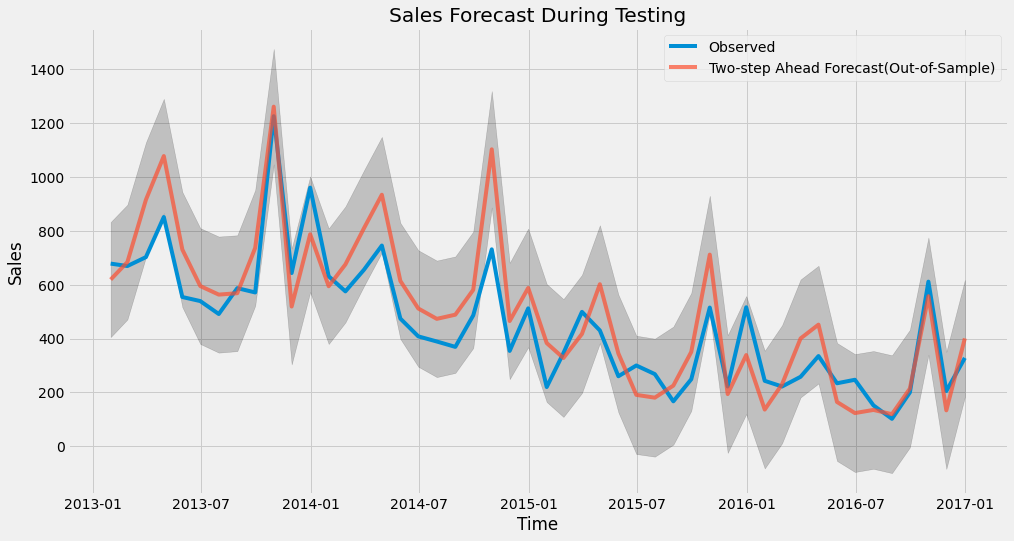

In [ ]:
# Plotting Sales v/s Time forecast during test period
ax = test_metrics["Observed"].plot(label='Observed',figsize=(15, 8))
test_metrics["Forecast(mean)"].plot(ax=ax, label='Two-step Ahead Forecast(Out-of-Sample)', alpha=.7)
ax.fill_between(test_metrics.index,test_metrics.iloc[:,3],test_metrics.iloc[:,2], color='k', alpha=.2)
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
plt.title("Sales Forecast During Testing")
plt.legend()

plt.show()

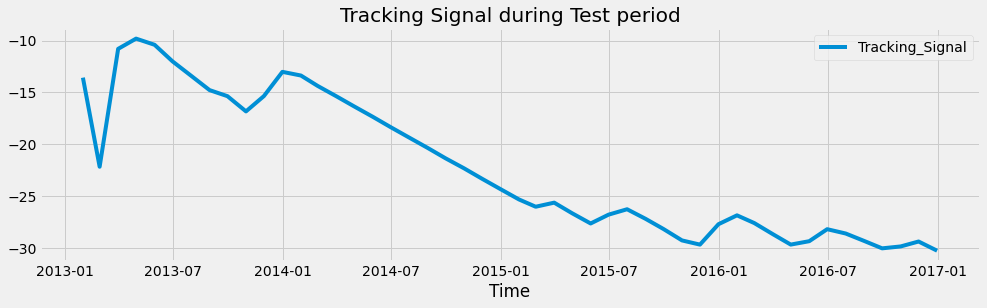

In [ ]:
#Plotting Tracking Signal
ax = test_metrics["Tracking_Signal"].plot(figsize=(15,4))
plt.title("Tracking Signal during Test period")
ax.set_xlabel('Time')
plt.legend()
plt.show()

# Observation: Since our tracking signal is continuosly below -4.5 , we can say that our model is Overcasting most of the time.

In [ ]:
#Test Metrics

# Compute the Root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test_metrics["Observed"], test_metrics["Forecast(mean)"]))

# Calculating MAPE during validation
percent_forecast_errors = abs(test_metrics["Observed"] - test_metrics["Forecast(mean)"])*100/test_metrics["Observed"] 
MAPE = sum(percent_forecast_errors)*1.0/len(percent_forecast_errors)

# Prediction Interval
Prediction_interval = test_metrics["Length_Predicion_Interval"].mean()

# Storing Results in Dictionary
ARIMA_Test_Results = {"Test RMSE":round(rmse,2),"Test MAPE":round(MAPE,2),"Testing Average Prediction Interval":round(Prediction_interval,2)} 
print(ARIMA_Test_Results)

{'Test RMSE': 125.36, 'Test MAPE': 25.22, 'Testing Average Prediction Interval': 433.39}


ARIMA Test Results :
{'Test RMSE': 125.36, 'Test MAPE': 25.22, 'Test Average Prediction Interval': 433.39}

References:


1.   https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

